In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import patches
from matplotlib.pyplot import figure

import sys
sys.path.append('..')

# local library of functions to connect to image server
import calcimetry.use_server as server
from calcimetry.mongo_api import MongoInfo, MongoAPI


# Open Image and get calcimetry for image

In [2]:
img_path = server.init()  # initiate the global (privatevariables for the database

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [3]:
mongo_info = MongoInfo()

In [5]:
drillname = 'DIR2002'
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    partialdrillname = f'.*{drillname}.*'
    doc = mongo_api.db['measurements'].find({'DrillName': {'$regex' : partialdrillname}})
    df = pd.DataFrame(list(doc))
df

,_id,MeasureId,ImageId,CalciCote,CalciVals1m,CalciVals15m,DrillName
0,630e28ae1f0101bf68355025,None,154,1308.0,35,39,DIR2002
1,630e28ae1f0101bf68355026,None,155,1308.0,35,39,DIR2002
2,630e28ae1f0101bf68355027,None,155,1347.0,25,27,DIR2002
3,630e28ae1f0101bf68355028,None,156,1347.0,25,27,DIR2002
4,630e28ae1f0101bf68355029,None,156,1375.0,18,20,DIR2002
5,630e28ae1f0101bf6835502a,None,156,1424.0,14,17,DIR2002
6,630e28ae1f0101bf6835502b,None,157,1424.0,14,17,DIR2002


Status Code 200


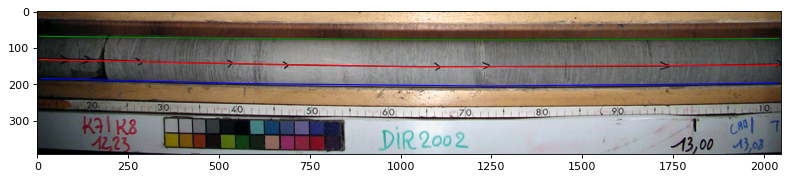

In [7]:
ImageId = 154

def draw_line(polyline, color='red'):
    x = []
    y = []
    for t in polyline:
        x.append(t[0])
        y.append(t[1])
    apath = Path(list(zip(x, y)))
    apatch = patches.PathPatch(apath, linewidth=1, facecolor='none', edgecolor=color)
    return apatch

with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find_one({'ImageId': ImageId})

    if len(doc['k_Up']) > 1:
        top_line = draw_line(doc['k_Up'], color='green')
    if doc['k_Arrow'] is not None:
        arrow_line = draw_line(doc['k_Arrow'], color='red')
    if len(doc['k_Down']) > 1:
        bottom_line = draw_line(doc['k_Down'], color='blue')

    filename = f"/data/andra/calci_photos/{drillname}/Photos/{doc['FileName']}"
    img = server.get_file(filename)

    figure(figsize=(12, 8), dpi=80)
    plt.imshow(img)
    if len(doc['k_Up']) > 1:
        plt.gca().add_patch(top_line)
    if doc['k_Arrow'] is not None:
        plt.gca().add_patch(arrow_line)
    if len(doc['k_Down']) > 1:
        plt.gca().add_patch(bottom_line)

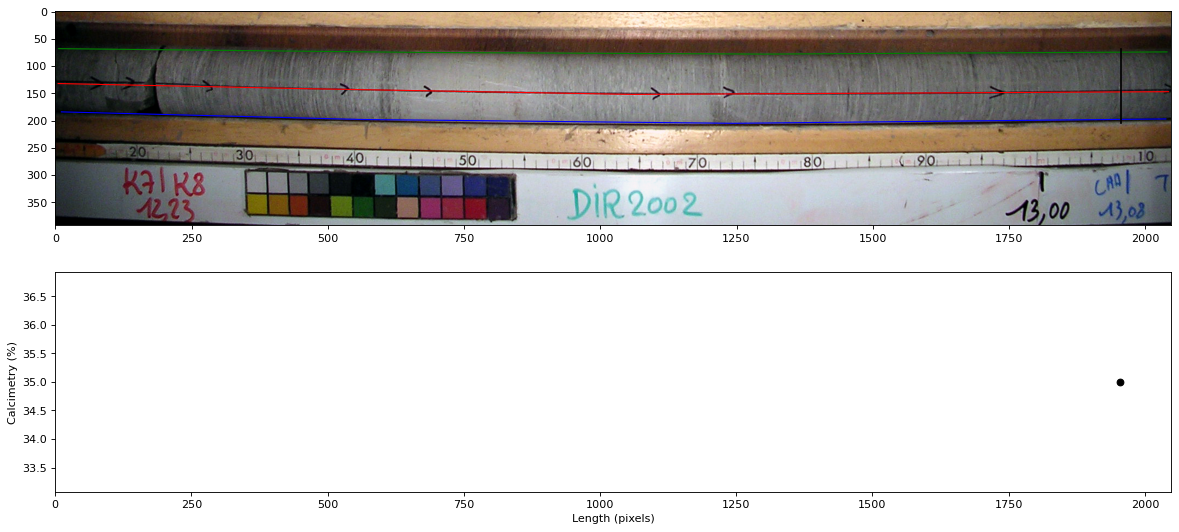

In [8]:
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find_one({'ImageId': ImageId})

    if len(doc['k_Up']) > 1:
        top_line = draw_line(doc['k_Up'], color='green')
    if doc['k_Arrow'] is not None:
        arrow_line = draw_line(doc['k_Arrow'], color='red')
    if len(doc['k_Down']) > 1:
        bottom_line = draw_line(doc['k_Down'], color='blue')

    filename = f"/data/andra/calci_photos/{drillname}/Photos/{doc['FileName']}"
    img = server.get_file(filename, quiet=True)

    figure(figsize=(18, 8), dpi=80)
    plt.subplot(211)
    plt.imshow(img)
    if len(doc['k_Up']) > 1:
        plt.gca().add_patch(top_line)
    if doc['k_Arrow'] is not None:
        plt.gca().add_patch(arrow_line)
    if len(doc['k_Down']) > 1:
        plt.gca().add_patch(bottom_line)
        
    dpxdx = (doc['px1'] - doc['px0']) / (doc['Cote1'] - doc['Cote0'])
        
    for indx, row in df.iterrows():
        if row['ImageId'] == ImageId:
            x = dpxdx * (row['CalciCote'] - doc['Cote0']) + doc['px0']
            y1 = np.array(doc['k_Down']).T[1].max()
            y2 = np.array(doc['k_Up']).T[1].min()
            plt.plot([x, x], [y1, y2], color='black')
    
    plt.subplot(212)
    
    x = []
    y = []
    for indx, row in df.iterrows():
        if row['ImageId'] == ImageId:
            x.append(dpxdx * (row['CalciCote'] - doc['Cote0']) + doc['px0'])
            y.append(row['CalciVals1m'])
    plt.plot(x, y, marker='o', color='black')
    plt.xlim(0, np.shape(img)[1])
    plt.ylabel('Calcimetry (%)')
    plt.xlabel('Length (pixels)')
            